# Area analysis and trends

In [ ]:
%reset

import matplotlib.pyplot as plt
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
import statsmodels.api as sma
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator
from matplotlib.gridspec import GridSpec
import pylab
from PIL import Image, ImageDraw
from scipy import signal
import warnings
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import datetime
import time
import glob
import numpy as np
import math
import os
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
warnings.filterwarnings('ignore')
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Analises_GEE/Avaliacao_Areas_geometry/'

n_area = [i+1 for i in range(29)]

result = pd.DataFrame()


#Note:* The order of the downloaded areas in the script is not the same as in the manuscript.
#To match the manuscript's order, we use the following mapping:

k_dict = {1: 16, 2: 15, 3: 18, 4: 17, 5: 19, 6: 20, 7: 21, 8: 22, 9: 23, 10: 24,
          11: 25, 12: 26, 13: 27, 14: 28, 15: 29, 16: 11, 17: 10, 18: 12, 19: 13,
          20: 14, 21: 6, 22: 7, 23: 8, 24: 9, 25: 3, 26: 4, 27: 5, 28: 2, 29: 1}


for narea in n_area:

    k = k_dict.get(narea, narea)

    #print(k)
    areadir = 'Area'+ str(narea)

    tmpDry = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Dry.csv")
    tmpDry.drop("Unnamed: 0",axis=1, inplace=True)
    tmpDry["maximum_2m_air_temperature"] =  tmpDry["maximum_2m_air_temperature"] - 273.15
    tmpDry["Percent"] = 100 - tmpDry["Percent"] #Deforestation Fraction
    tmpDry["Type"] = "Dry"
    tmpDry["Area"] = k

    tmpWet = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Wet.csv")
    tmpWet.drop("Unnamed: 0",axis=1, inplace=True)
    tmpWet["maximum_2m_air_temperature"] =  tmpWet["maximum_2m_air_temperature"] - 273.15
    tmpWet["Percent"] = 100 - tmpWet["Percent"] #Deforestation Fraction
    tmpWet["Type"] = "Wet"
    tmpWet["Area"] = k

    tmpTotal = pd.read_csv(path + "/" + areadir + "/Total_Area/yearly_average/" + areadir + "_Total.csv")
    tmpTotal.drop("Unnamed: 0",axis=1, inplace=True)
    tmpTotal["maximum_2m_air_temperature"] =  tmpTotal["maximum_2m_air_temperature"] - 273.15
    tmpTotal["Percent"] = 100 - tmpTotal["Percent"] #Deforestation Fraction
    tmpTotal["Type"] = "Total"
    tmpTotal["Area"] = k

    # Append the data of each iteration to the main dataframe
    result = result.append([tmpDry, tmpWet, tmpTotal], ignore_index=True) #, tmpTotal
#result = result[result['date'] > 2002]



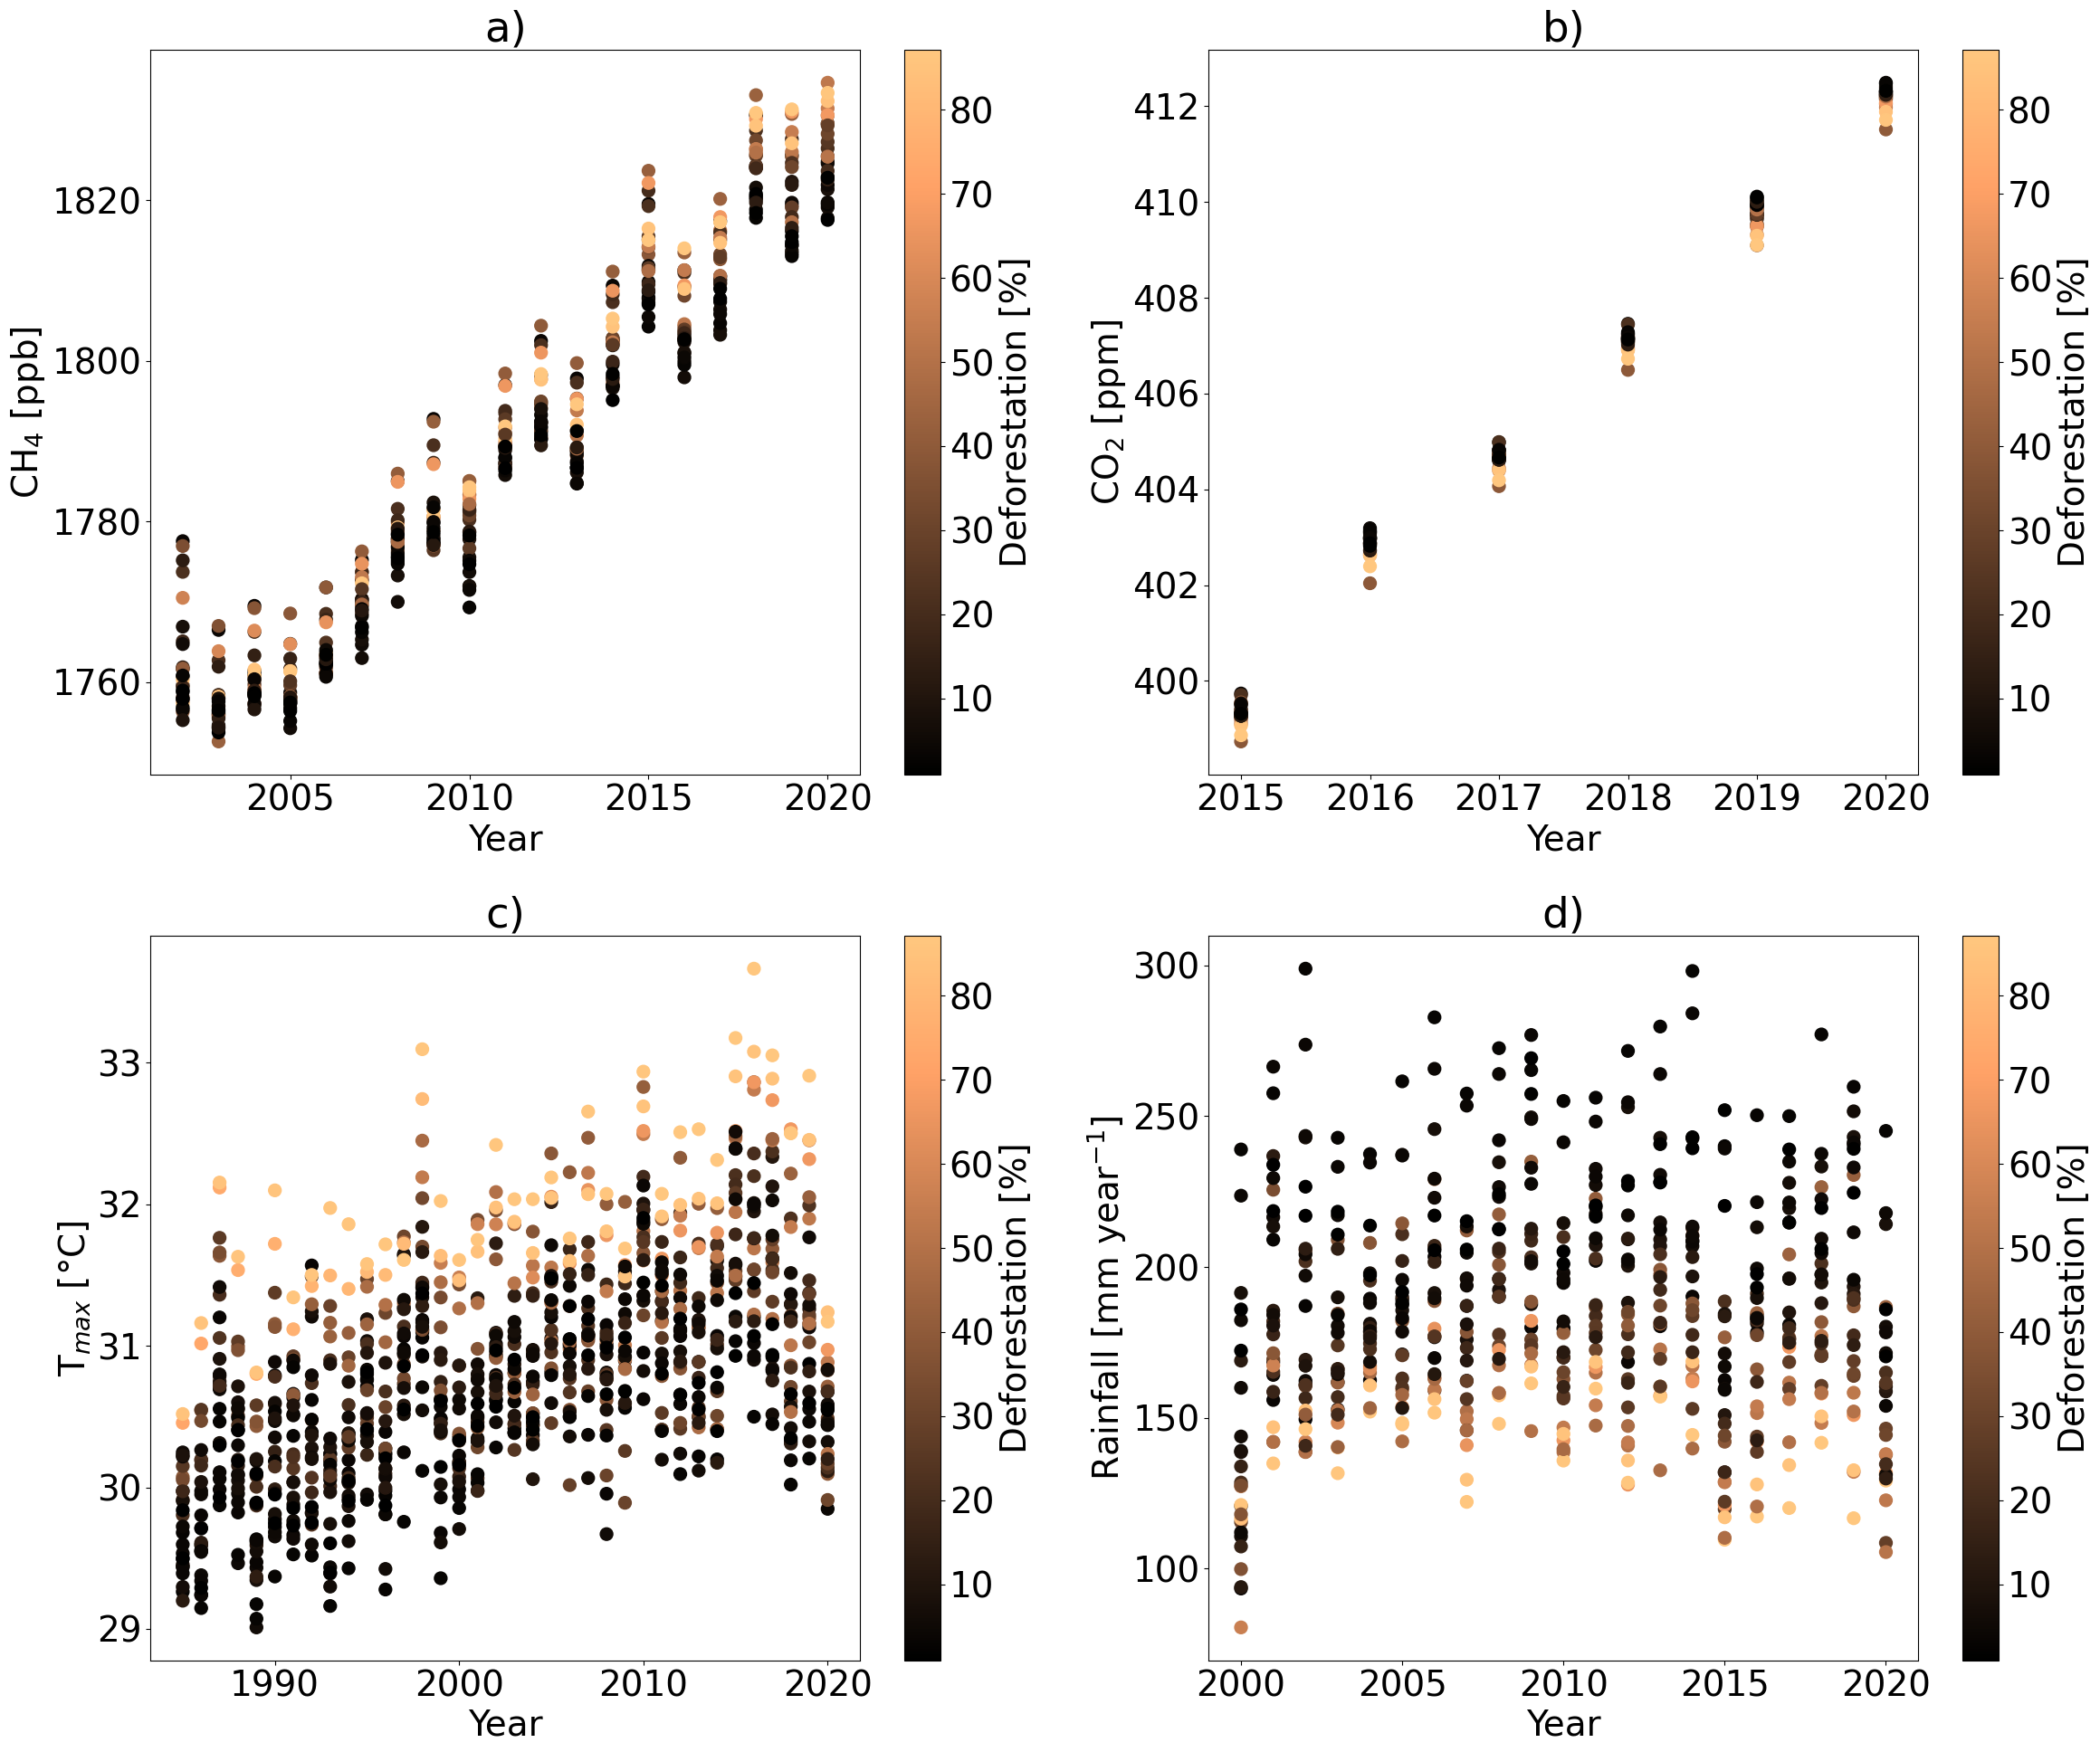

In [ ]:
###Ploting Figure S3 manuscript

df_notnull_dry = result[result['Type'] == 'Total']

plt.rcParams.update({'font.size': 28})
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

scatter1 = axes[0, 0].scatter(df_notnull_dry['date'], df_notnull_dry['mean_CH4'], 100, df_notnull_dry['Percent'], cmap='copper')
axes[0, 0].set_title('a)')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('CH$_4$ [ppb]')
cbar1 = fig.colorbar(scatter1, ax=axes[0, 0])
axes[0, 0].tick_params(axis='both', which='both')
cbar1.set_label('Deforestation [%]')

scatter2 = axes[0, 1].scatter(df_notnull_dry['date'], df_notnull_dry['mean_CO2'], 100, df_notnull_dry['Percent'], cmap='copper')
axes[0, 1].set_title('b)')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('CO$_2$ [ppm]')
cbar2 = fig.colorbar(scatter2, ax=axes[0, 1])
axes[0, 1].tick_params(axis='both', which='both')
cbar2.set_label('Deforestation [%]')

scatter3 = axes[1, 0].scatter(df_notnull_dry['date'], df_notnull_dry['maximum_2m_air_temperature'], 100, df_notnull_dry['Percent'], cmap='copper')
axes[1, 0].set_title('c)')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('T$_{max}$ [°C]')
cbar3 = fig.colorbar(scatter3, ax=axes[1, 0])
axes[1, 0].tick_params(axis='both', which='both')
cbar3.set_label('Deforestation [%]')

scatter4 = axes[1, 1].scatter(df_notnull_dry['date'], df_notnull_dry['precip_mm_month'], 100, df_notnull_dry['Percent'], cmap='copper')
axes[1, 1].set_title('d)')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Rainfall [mm year$^{-1}$]')
cbar4 = fig.colorbar(scatter4, ax=axes[1, 1])
axes[1, 1].tick_params(axis='both', which='both')
cbar4.set_label('Deforestation [%]')

plt.tight_layout()

#fig.savefig('FigureS3.pdf', dpi=500, bbox_inches='tight', format='pdf')

plt.show()


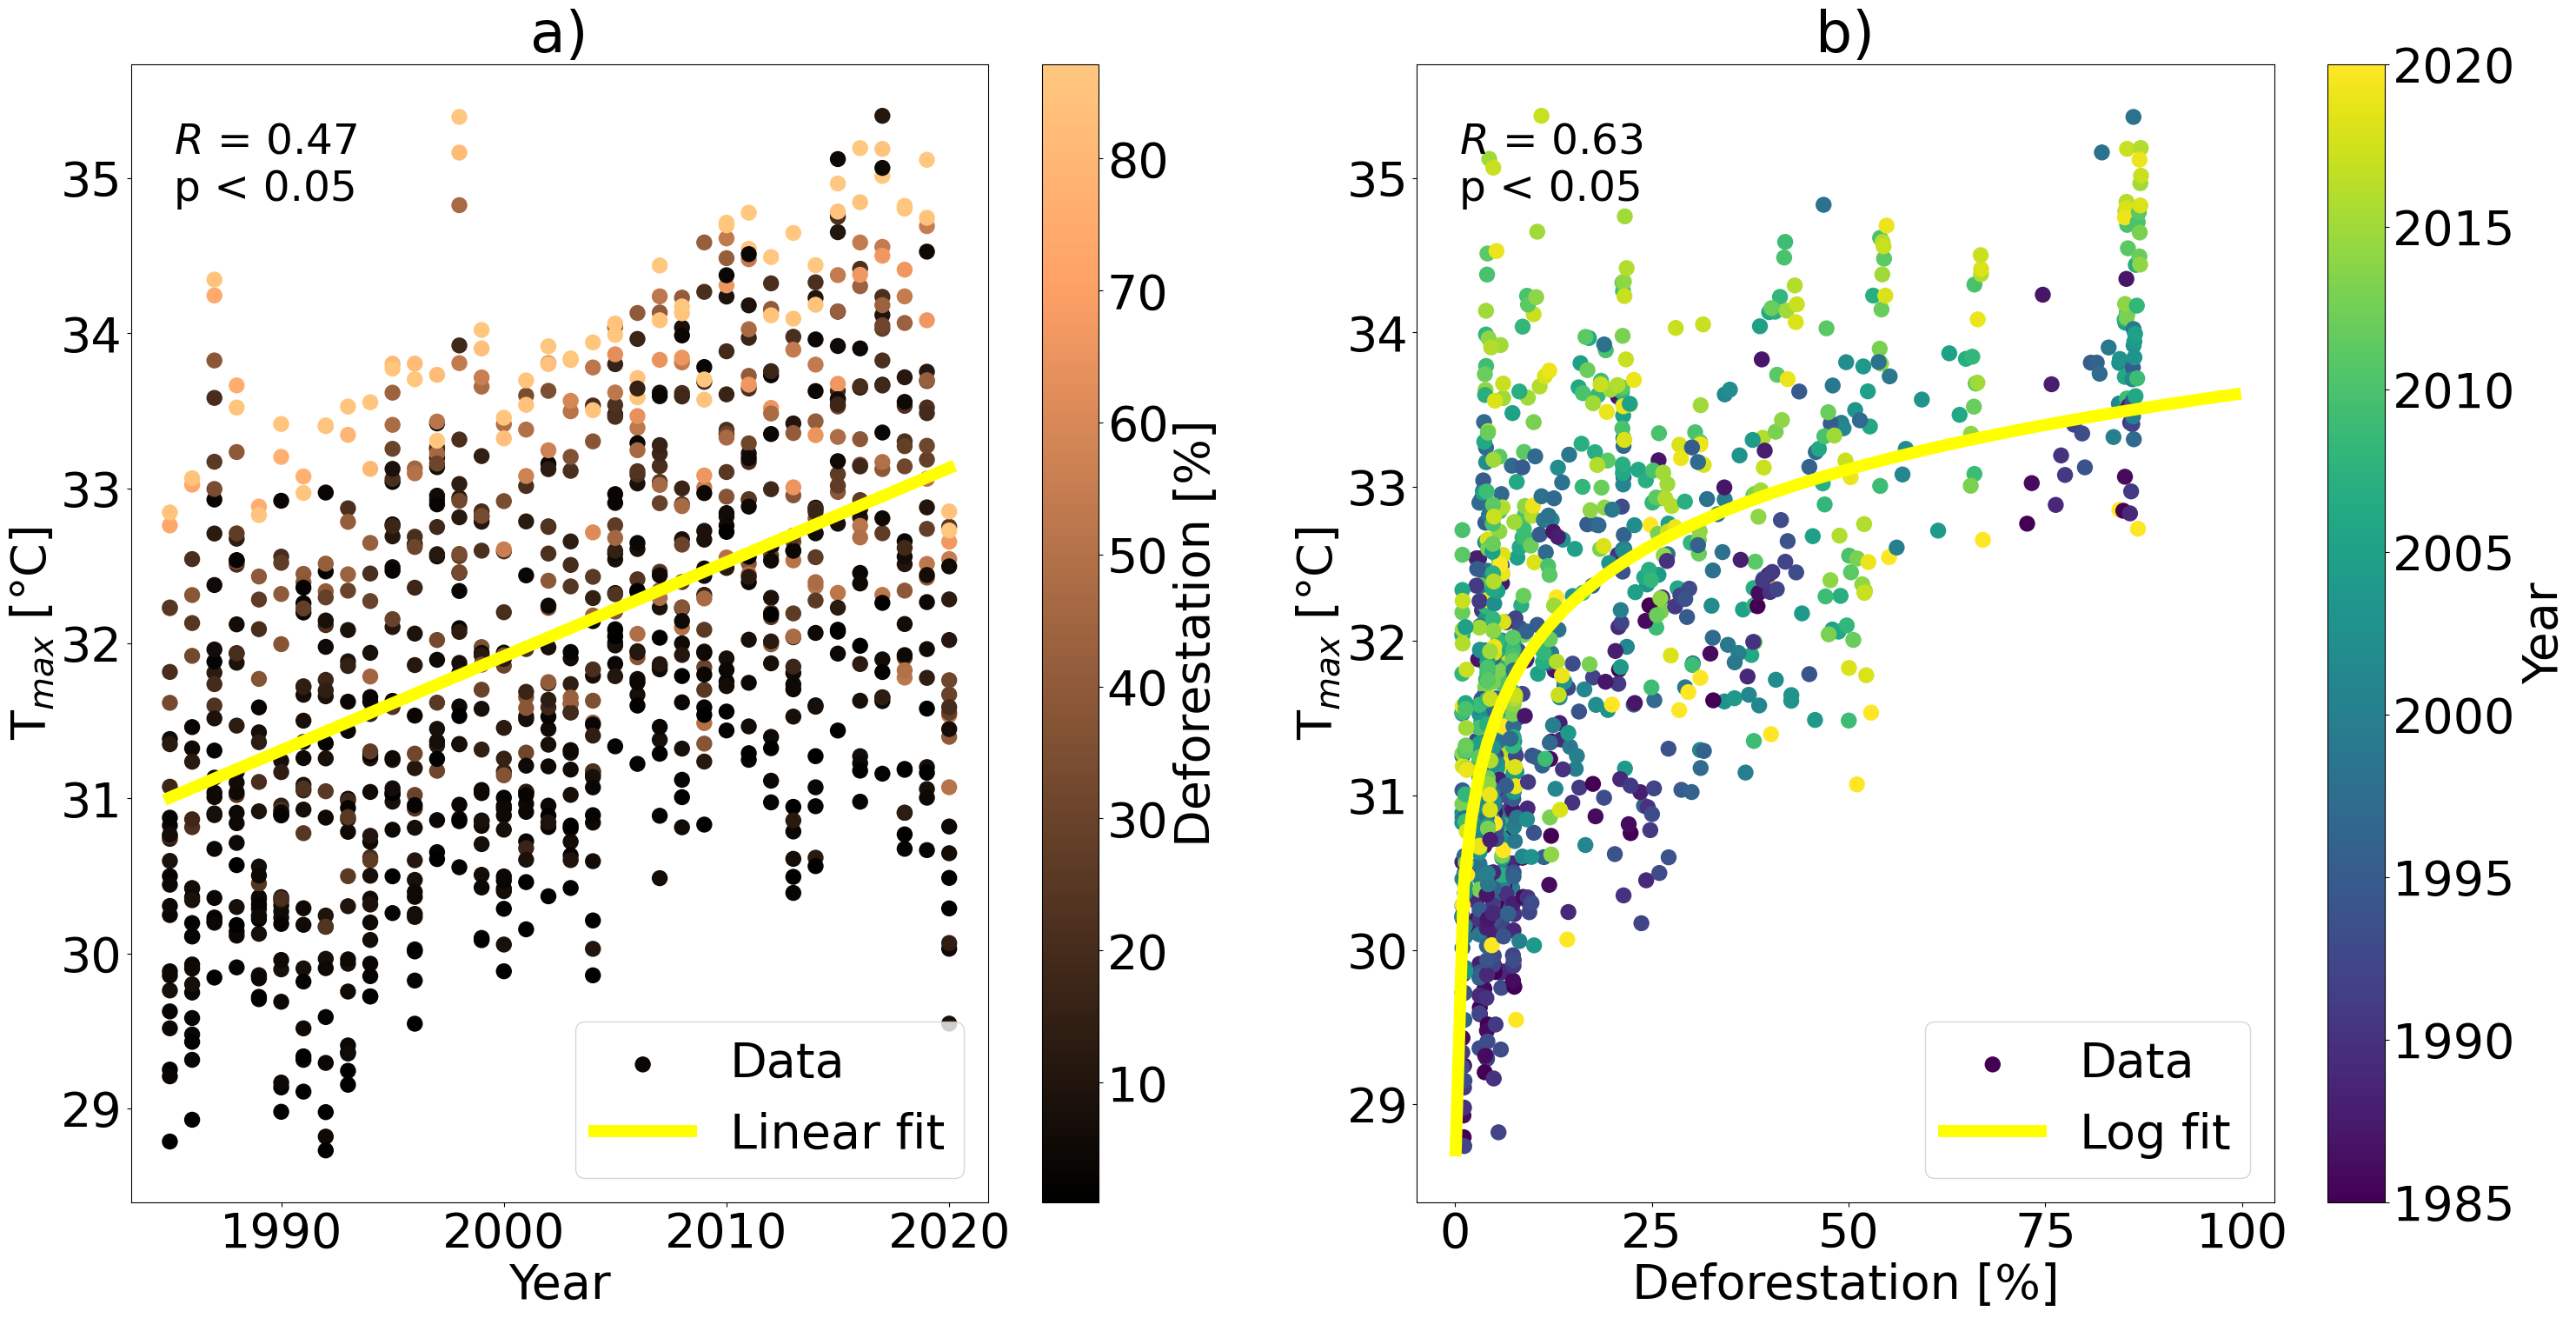

In [ ]:
###Figure 2 manuscript

# Seleciona os dados
df_notnull_dry = result[(result['Type'] == 'Dry') & (result['date'] > 1980) & (result['maximum_2m_air_temperature'].notnull())]
df_notnull_dry_2013 = result[(result['Type'] == 'Dry') & (result['date'] >= 1985) & (result['maximum_2m_air_temperature'].notnull())]

# === AJUSTE LINEAR ===
def func_linear(x, a, b):
    return a * x + b

x1 = df_notnull_dry['date'].values
y1 = df_notnull_dry['maximum_2m_air_temperature'].values

popt_linear, _ = curve_fit(func_linear, x1, y1, p0=[1, 1])
y_pred1 = func_linear(x1, *popt_linear)

# R e valor-p (linear)
slope, intercept, r_value, p_value_linear, _ = linregress(x1, y1)
r_linear = r_value

# === AJUSTE LOGARÍTMICO ===
def func_log(x, a, b):
    return a * np.log(x) + b

x2_raw = df_notnull_dry['Percent'].values
y2 = df_notnull_dry['maximum_2m_air_temperature'].values

# Remover log(0) ou valores não finitos
mask_log = (x2_raw > 0) & np.isfinite(x2_raw)
x2_clean = x2_raw[mask_log]
y2_clean = y2[mask_log]

# Ajuste logarítmico
popt_log, _ = curve_fit(func_log, x2_clean, y2_clean, p0=[1, 1])
x2_plot = np.arange(0.1, 100, 1)
y_pred2 = func_log(x2_plot, *popt_log)

# R e valor-p (log)
X_log = sm.add_constant(np.log(x2_clean))
model_log = sm.OLS(y2_clean, X_log).fit()
r_log = np.sqrt(model_log.rsquared)
pval_log = model_log.pvalues[1]

# === PLOTAGEM ===
plt.rcParams.update({'font.size': 40})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 17))

# Subplot (a): linear
ax = axes[0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['maximum_2m_air_temperature'],
                      c=df_notnull_dry['Percent'], cmap='copper', s=150, label='Data')
ax.set_ylabel('T$_{max}$ [°C]')
ax.set_xlabel('Year')
ax.set_title("a)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')
ax.plot(x1, y_pred1, color='yellow', linewidth=10, label='Linear fit')
ax.legend()

# Adiciona estatísticas (subplot a)
p_text_linear = "p < 0.05" if p_value_linear < 0.05 else f"p = {p_value_linear:.2e}"
ax.text(0.05, 0.95, f"$R$ = {r_linear:.2f}\n{p_text_linear}",
        transform=ax.transAxes, fontsize=35, verticalalignment='top')

# Subplot (b): log
ax = axes[1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['maximum_2m_air_temperature'],
                      c=df_notnull_dry_2013["date"], s=150, cmap='viridis', label='Data')
ax.set_ylabel('T$_{max}$ [°C]')
ax.set_xlabel('Deforestation [%]')
ax.set_title("b)")
cbar2 = plt.colorbar(scatter3, ax=ax)
cbar2.set_label('Year')
ax.plot(x2_plot, y_pred2, color='yellow', linewidth=10, label='Log fit')
ax.legend()

# Adiciona estatísticas (subplot b)
p_text_log = "p < 0.05" if pval_log < 0.05 else f"p = {pval_log:.2e}"
ax.text(0.05, 0.95, f"$R$ = {r_log:.2f}\n{p_text_log}",
        transform=ax.transAxes, fontsize=35, verticalalignment='top')

# Salvar se desejar
#fig.savefig('Figure2.png', dpi=500, bbox_inches='tight', format='pdf')

plt.show()


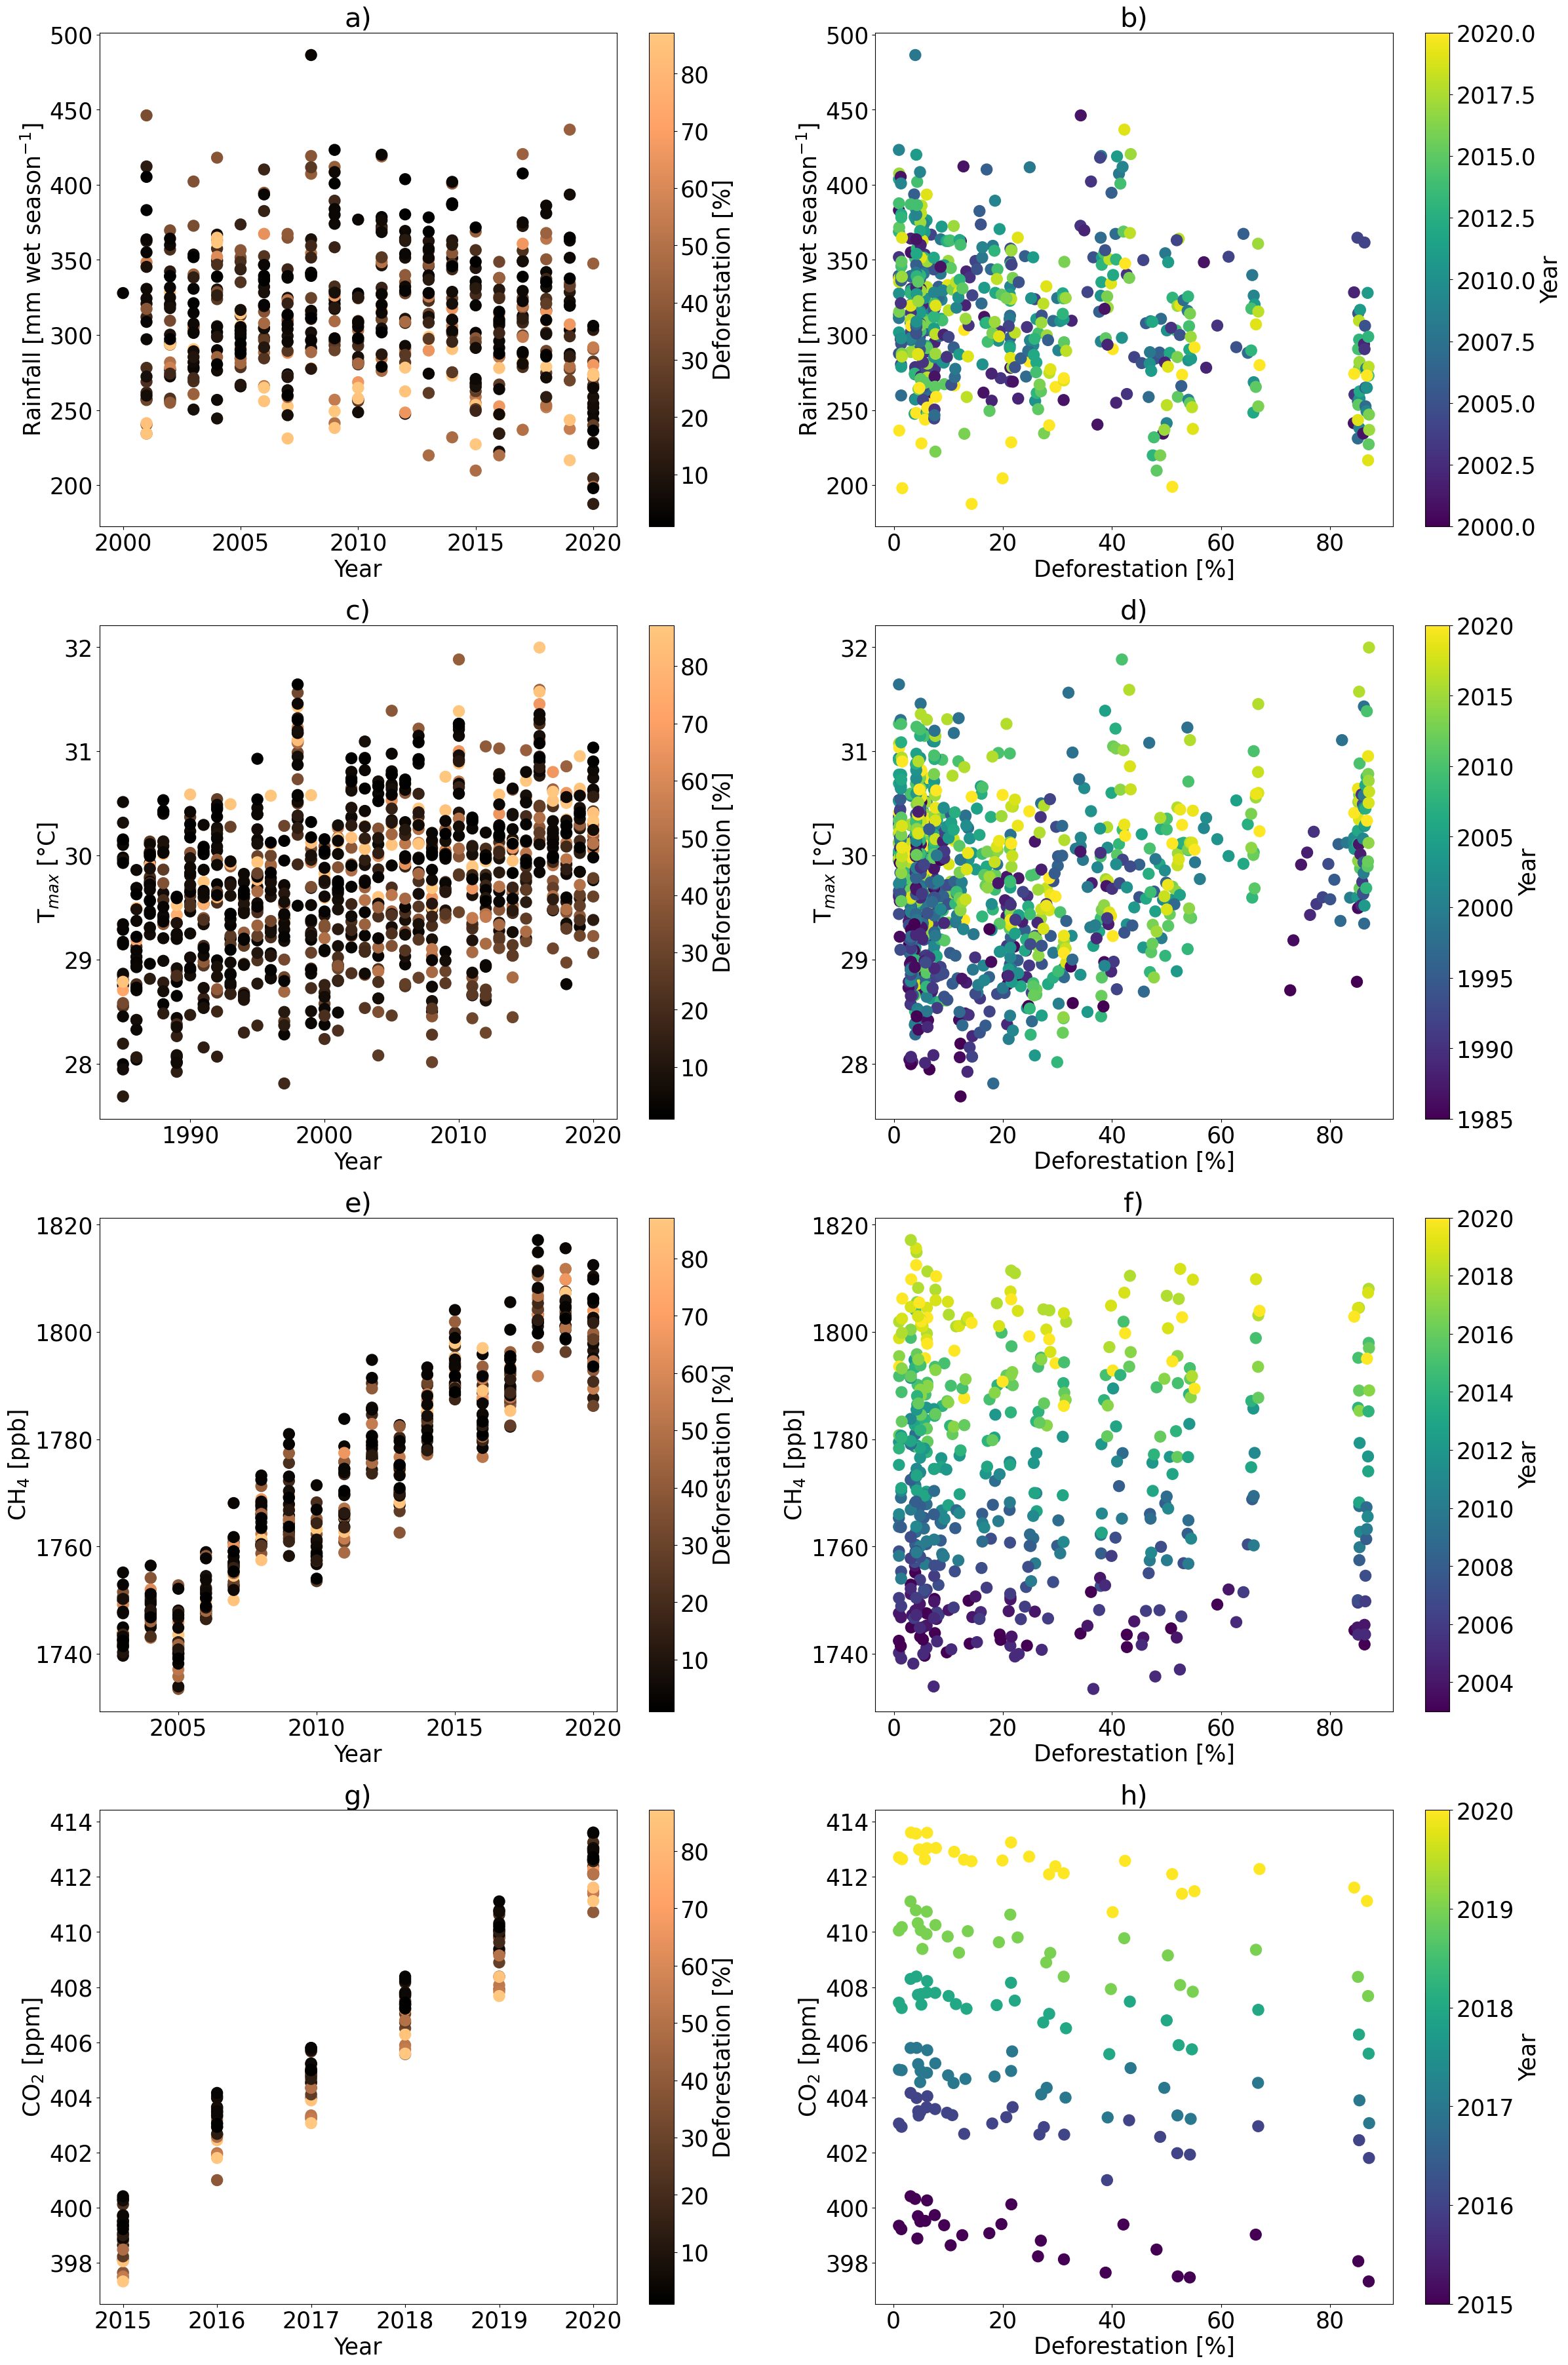

In [ ]:
#Similar ao anterior, mas feito com Tmax
# Select data
df_notnull_dry = result[result['Type'] == 'Wet']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 1980]
df_notnull_dry = df_notnull_dry[df_notnull_dry['precip_mm_month'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Wet']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 1985]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['precip_mm_month'].notnull()]

# Create the subplots in a 2x2 grid
plt.rcParams.update({'font.size': 25})
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(28, 45))

# Plot the first subplot
ax = axes[0,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['precip_mm_month'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('Rainfall [mm wet season$^{-1}$]'); ax.set_xlabel('Year')
ax.set_title("a)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[0,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['precip_mm_month'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('Rainfall [mm wet season$^{-1}$]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("b)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')

df_notnull_dry = result[result['Type'] == 'Wet']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 2000]
df_notnull_dry = df_notnull_dry[df_notnull_dry['porcentagem'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Wet']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 2000]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['porcentagem'].notnull()]

df_notnull_dry = result[result['Type'] == 'Wet']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 2000]
df_notnull_dry = df_notnull_dry[df_notnull_dry['mean_CH4'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Wet']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 2000]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['mean_CH4'].notnull()]

ax = axes[2,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['mean_CH4'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('CH$_4$ [ppb]'); ax.set_xlabel('Year')
ax.set_title("e)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[2,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['mean_CH4'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('CH$_4$ [ppb]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("f)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')

df_notnull_dry = result[result['Type'] == 'Wet']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 2000]
df_notnull_dry = df_notnull_dry[df_notnull_dry['mean_CO2'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Wet']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 2000]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['mean_CO2'].notnull()]

ax = axes[3,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['mean_CO2'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('CO$_2$ [ppm]'); ax.set_xlabel('Year')
ax.set_title("g)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[3,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['mean_CO2'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('CO$_2$ [ppm]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("h)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')

df_notnull_dry = result[result['Type'] == 'Wet']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 1984]
df_notnull_dry = df_notnull_dry[df_notnull_dry['maximum_2m_air_temperature'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Wet']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 1985]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['maximum_2m_air_temperature'].notnull()]

ax = axes[1,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['maximum_2m_air_temperature'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('T$_{max}$ [°C]'); ax.set_xlabel('Year')
ax.set_title("c)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[1,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['maximum_2m_air_temperature'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('T$_{max}$ [°C]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("d)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')

os.chdir('G:/Outros computadores/USP_PC//Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo')
fig.savefig('FigureS9.pdf', dpi=500, bbox_inches='tight', format='pdf')

# Show the plots
plt.show()

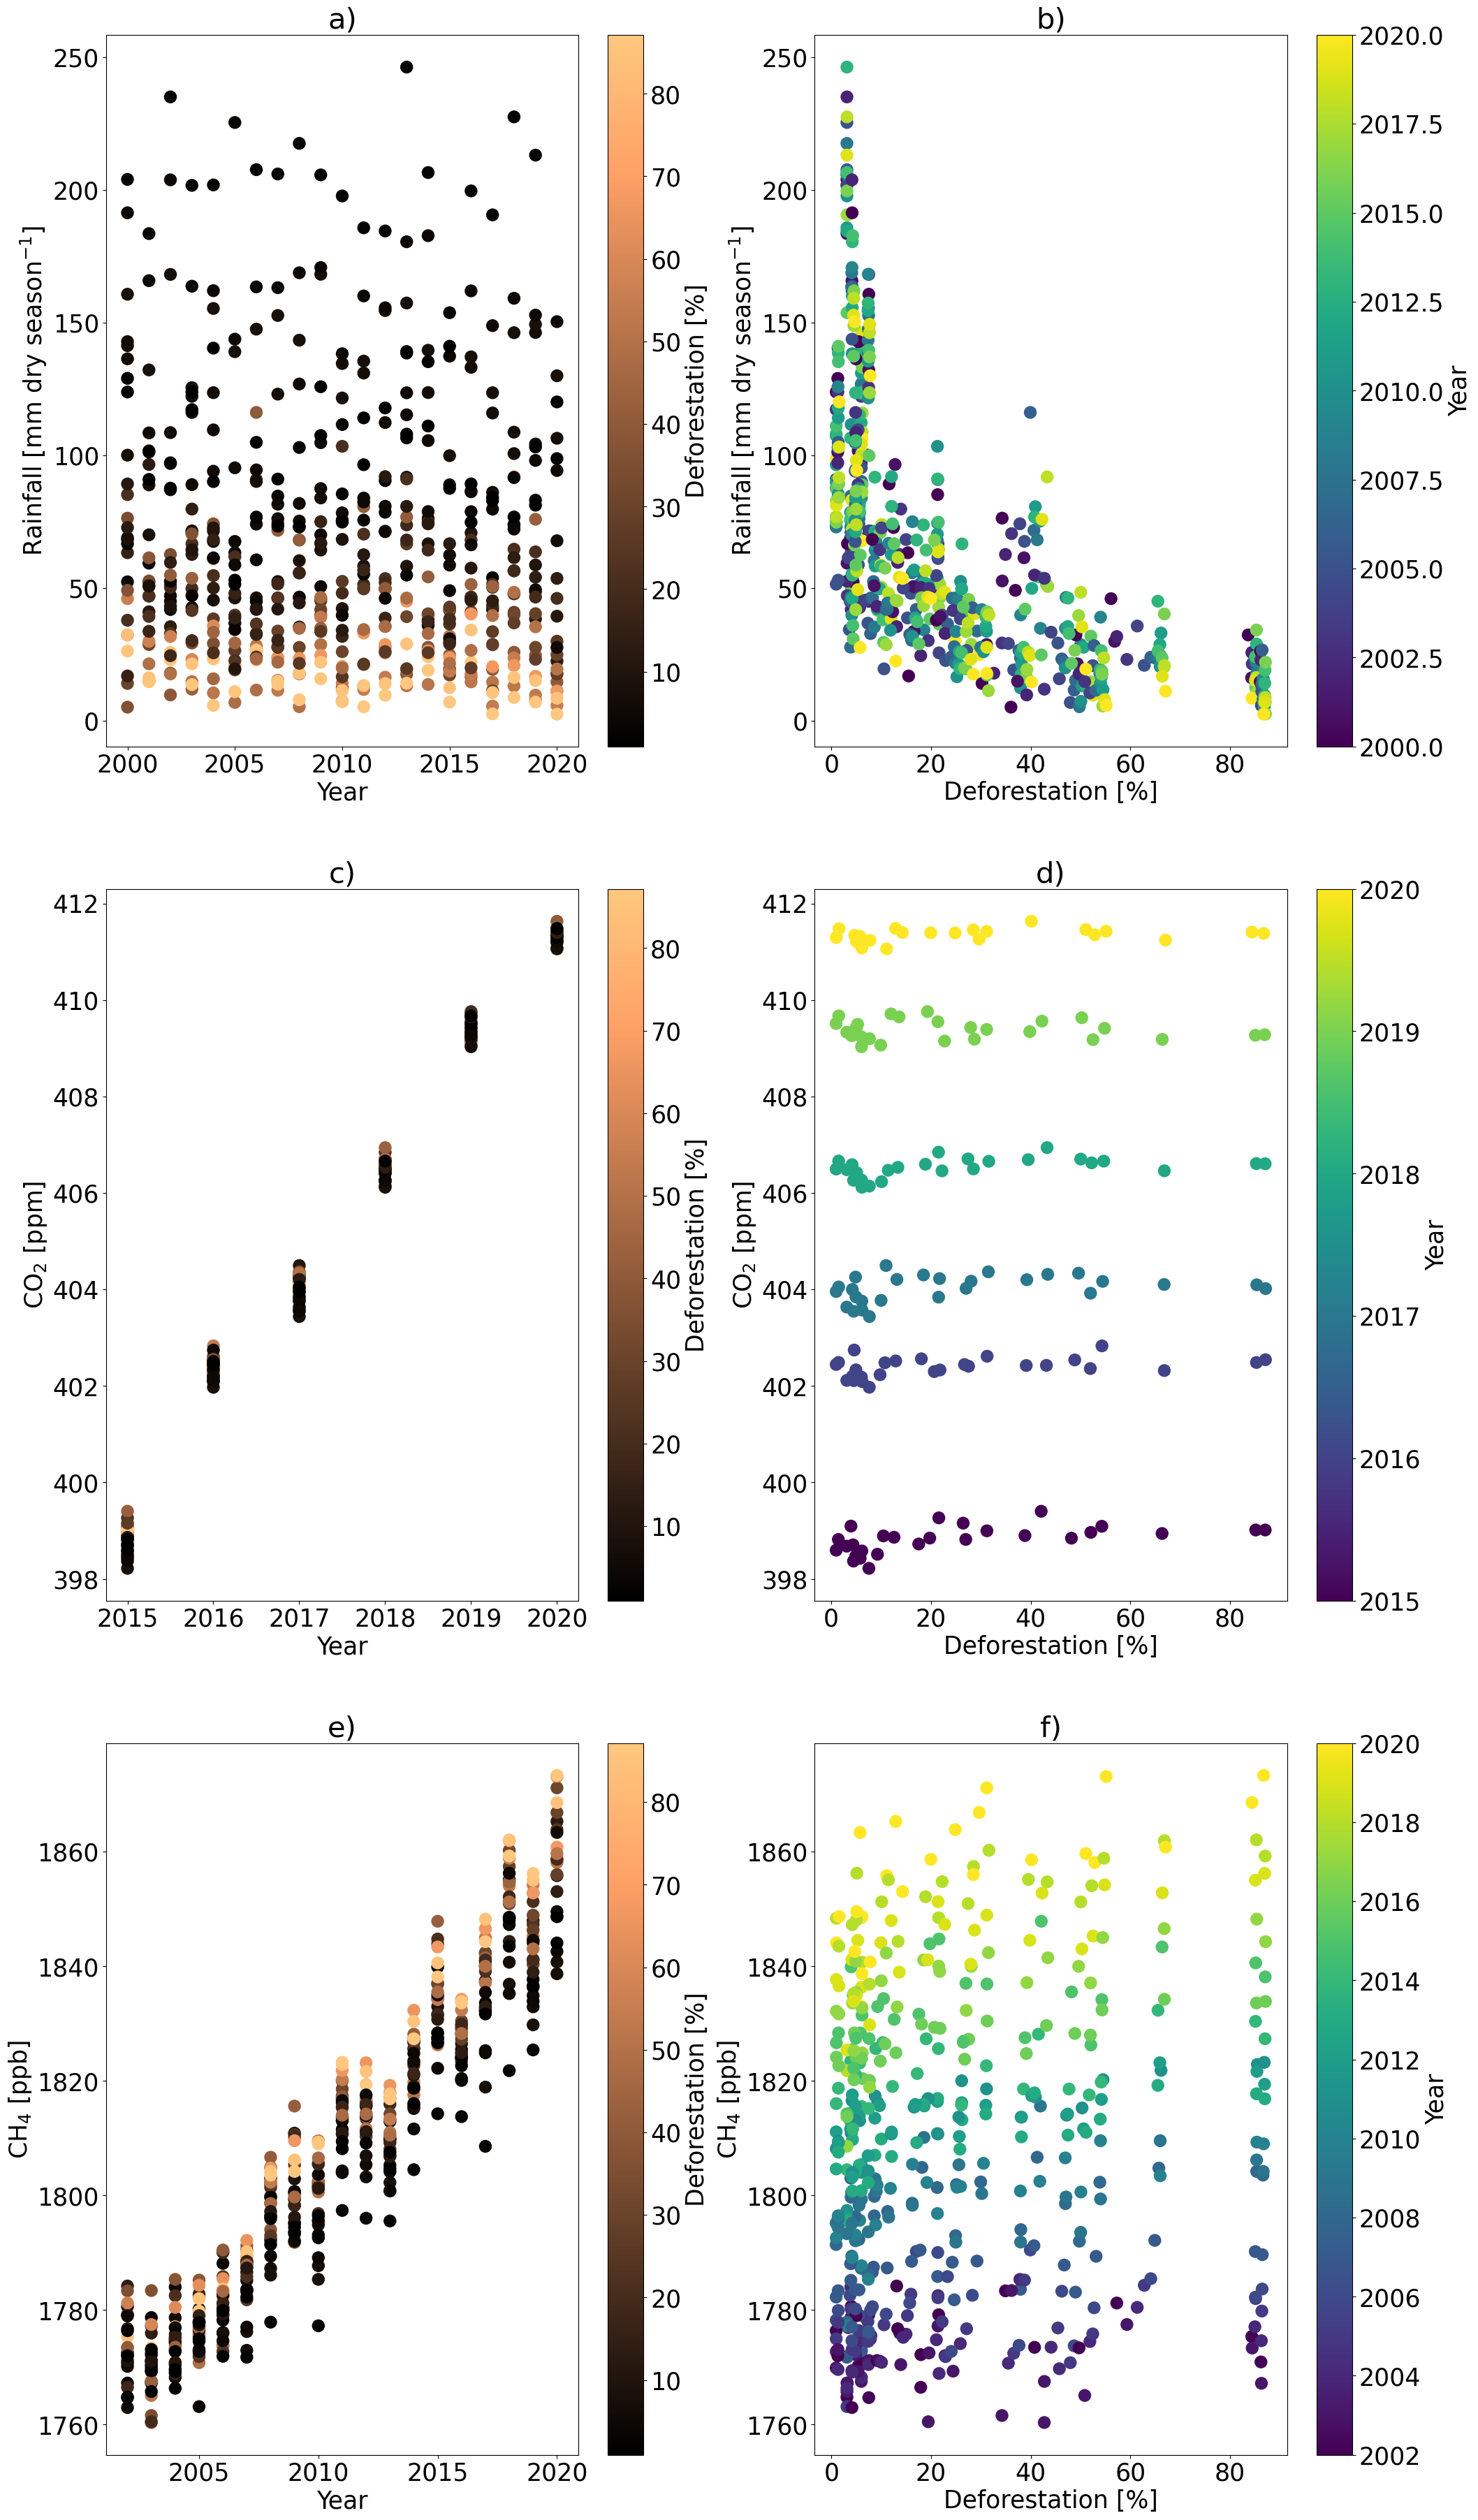

In [ ]:
#Figure S8 manuscript

# Select data
df_notnull_dry = result[result['Type'] == 'Dry']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 1980]
df_notnull_dry = df_notnull_dry[df_notnull_dry['precip_mm_month'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Dry']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 1985]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['precip_mm_month'].notnull()]

# Create the subplots in a 2x2 grid
plt.rcParams.update({'font.size': 25})
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 45))

# Plot the first subplot
ax = axes[0,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['precip_mm_month'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('Rainfall [mm dry season$^{-1}$]'); ax.set_xlabel('Year')
ax.set_title("a)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[0,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['precip_mm_month'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('Rainfall [mm dry season$^{-1}$]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("b)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')

df_notnull_dry = result[result['Type'] == 'Dry']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 2000]
df_notnull_dry = df_notnull_dry[df_notnull_dry['porcentagem'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Dry']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 2000]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['porcentagem'].notnull()]

df_notnull_dry = result[result['Type'] == 'Dry']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 2000]
df_notnull_dry = df_notnull_dry[df_notnull_dry['mean_CH4'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Dry']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 2000]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['mean_CH4'].notnull()]

ax = axes[2,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['mean_CH4'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('CH$_4$ [ppb]'); ax.set_xlabel('Year')
ax.set_title("e)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[2,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['mean_CH4'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('CH$_4$ [ppb]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("f)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')

df_notnull_dry = result[result['Type'] == 'Dry']
df_notnull_dry = df_notnull_dry[df_notnull_dry['date'] > 2000]
df_notnull_dry = df_notnull_dry[df_notnull_dry['mean_CO2'].notnull()]
df_notnull_dry_2013 = result[result['Type'] == 'Dry']
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['date'] >= 2000]
df_notnull_dry_2013 = df_notnull_dry_2013[df_notnull_dry_2013['mean_CO2'].notnull()]

ax = axes[1,0]
scatter1 = ax.scatter(df_notnull_dry['date'], df_notnull_dry['mean_CO2'], c=df_notnull_dry['Percent'], cmap='copper',s=150)
ax.set_ylabel('CO$_2$ [ppm]'); ax.set_xlabel('Year')
ax.set_title("c)")
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label('Deforestation [%]')

# Plot the third subplot
ax = axes[1,1]
scatter3 = ax.scatter(df_notnull_dry_2013['Percent'], df_notnull_dry_2013['mean_CO2'], c=df_notnull_dry_2013["date"],s=150)
ax.set_ylabel('CO$_2$ [ppm]'); ax.set_xlabel('Deforestation [%]')
ax.set_title("d)")
cbar1 = plt.colorbar(scatter3, ax=ax)
cbar1.set_label('Year')


os.chdir('G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo')
fig.savefig('FigureS3.pdf', dpi=300, bbox_inches='tight', format='pdf')

# Show the plots
plt.show()

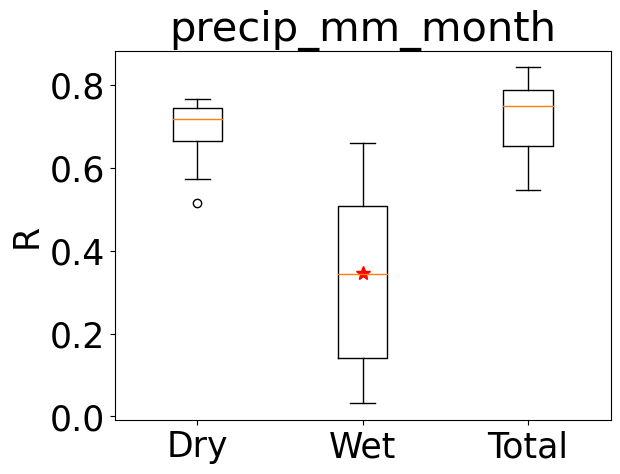

    Dry_pval  Wet_pval    Total_pval       Dry       Wet     Total
0   0.000114  0.026943  3.172025e-04  0.674631  0.425435  0.640776
1   0.001803  0.141598  4.807043e-04  0.572529  0.290480  0.625813
2   0.000012  0.619322  1.625458e-04  0.737224  0.100108  0.663300
3   0.000015  0.007278  1.017035e-03  0.731162  0.504546  0.596759
4   0.005950  0.236340  3.185110e-03  0.515266  0.235824  0.546486
5   0.001681  0.102615  1.286776e-03  0.575615  0.320950  0.587034
6   0.000341  0.793664  1.860909e-05  0.638244  0.052800  0.725382
7   0.000159  0.876629  1.671804e-05  0.663949  0.031353  0.728081
8   0.000010  0.000182  1.103342e-06  0.741385  0.659642  0.787298
9   0.000114  0.079482  1.924032e-06  0.674408  0.343399  0.776489
10  0.000006  0.843428  1.206483e-06  0.751191  0.039883  0.785601
11  0.000007  0.000295  2.290234e-07  0.748059  0.643303  0.814828
12  0.000007  0.006528  1.588010e-06  0.749090  0.510381  0.780288
13  0.000007  0.003613  4.143551e-06  0.749413  0.540424  0.76

In [ ]:
# Filtrar os dados para o tipo 'Dry'
df_wet = result[result['Type'] == 'Wet']
varr = 'precip_mm_month'     #maximum_2m_air_temperature
start = 2001
end =  2020
# Calcular o coeficiente de Pearson para cada ano de 1985 a 2019
years = range(start, end)
pearson_coeffs_wet = []
pvalor_wet = []

for year in years:
    df_year = df_wet[df_wet['date'] == year]
    df_year = df_year[df_year[varr].notnull()]

    x = df_year[["Percent", "date"]].values
    y = df_year[varr]

    def func(x, a, b):
        return a * np.log((x[:, 0])) + b

    a0 = 1
    b0 = 1

    popt, pcov = curve_fit(func, x, y, p0=[a0, b0])
    y_pred = func(x, *popt)

    corr, pvalW = pearsonr(y, y_pred)
    pearson_coeffs_wet.append(corr)
    pvalor_wet.append(pvalW)

df_dry = result[result['Type'] == 'Dry']

# Calcular o coeficiente de Pearson para cada ano de 1985 a 2019
pearson_coeffs_dry = []
pvalor_dry = []
cof = []
for year in years:
    df_year = df_dry[df_dry['date'] == year]
    df_year = df_year[df_year[varr].notnull()]

    x = df_year[["Percent", "date"]].values
    y = df_year[varr]

    def func(x, a, b):
        return a * np.log((x[:, 0])) + b

    a0 = 1
    b0 = 1

    popt, pcov = curve_fit(func, x, y, p0=[a0, b0])
    y_pred = func(x, *popt)

    #print("Angular =", round(popt[0], 2), "+/-", round(np.sqrt(pcov[1, 1]), 2))
    cof.append(popt[0])

    corr, pvalD = pearsonr(y, y_pred)
    pearson_coeffs_dry.append(corr)
    pvalor_dry.append(pvalD)

    #print(pvalD)
    #print(corr)

df_total = result[result['Type'] == 'Total']

pearson_coeffs_total = []
pvalor_tot = []

for year in years:
    df_year = df_total[df_total['date'] == year]
    df_year = df_year[df_year[varr].notnull()]

    x = df_year[["Percent", "date"]].values
    y = df_year[varr]

    def func(x, a, b):
        return a * np.log((x[:, 0])) + b

    a0 = 1
    b0 = 1

    popt, pcov = curve_fit(func, x, y, p0=[a0, b0])
    y_pred = func(x, *popt)

    corr, pvalT = pearsonr(y, y_pred)
    pearson_coeffs_total.append(corr)
    pvalor_tot.append(pvalT)

    # Print the parameters that were fitted and the correlation coefficient
    #print("Year:", year)
    #print("Linear =", round(popt[0], 2), "+/-", round(np.sqrt(pcov[0, 0]), 2))
    #print("Angular =", round(popt[1], 2), "+/-", round(np.sqrt(pcov[1, 1]), 2))
    #print("Pearson correlation coefficient =", round(corr, 2))
    #print(pval)

titles = []
if varr == "mean_CH4":
    varr = "CH$_4$ [ppb]"
    titles = 'a)'
if varr == 'mean_CO2':
    varr = "CO$_2$ [ppm]"
    titles = 'b)'
if varr == 'maximum_2m_air_temperature':
    varr = "T$_{max}$ [°C]"
    titles = 'c)'
if varr == 'total_precipitation':
    varr = 'Rainfall [mm]'
    titles = 'd)'
if varr == 'Num_Days':
    varr = 'Rainless days'
    titles = 'e)'

## Boxplot comparativo dos valores Dry, Wet e Total
data = [pearson_coeffs_dry, pearson_coeffs_wet, pearson_coeffs_total]
datap = [pvalor_dry, pvalor_wet, pvalor_tot]

labels = ['Dry', 'Wet', 'Total']

plt.figure()
plt.boxplot(data, labels=labels)
plt.xlabel('')
plt.ylabel('R')
plt.title(varr)


# Adicionar pontos com diferentes marcas aos boxplots
markers = ['*', '*', '*']  # Marcas dos pontos
idx = []


for i, box in enumerate(data):
    idx = np.where(np.array(datap[i]) > 0.05)
    box = np.array(box)

    if len(idx[0]) > 0:  # Verificar se existem índices válidos
        lim = np.max(box[idx])

        #print(lim)
        #print(idx)
        #print(box)

        if lim > 0:  # Verificar se lim é maior que 0
            plt.plot(i+1, lim, marker=markers[i], markersize=10, color='red')


os.chdir('G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/correlacoes/log')
plt.savefig(varr+'.png', dpi=300, bbox_inches='tight')
plt.show()

pvalor_dry = pd.DataFrame(pvalor_dry)
pvalor_wet = pd.DataFrame(pvalor_wet)
pvalor_total = pd.DataFrame(pvalor_tot)

df_pval = pd.DataFrame()
df_pval['Dry_pval'] = pvalor_dry
df_pval['Wet_pval'] = pvalor_wet
df_pval['Total_pval'] = pvalor_total

pearson_coeffs_dry = pd.DataFrame(pearson_coeffs_dry)
pearson_coeffs_wet = pd.DataFrame(pearson_coeffs_wet)
pearson_coeffs_total = pd.DataFrame(pearson_coeffs_total)

df_coef = pd.DataFrame()
df_coef['Dry'] = pearson_coeffs_dry
df_coef['Wet'] = pearson_coeffs_wet
df_coef['Total'] = pearson_coeffs_total

df_combined = pd.DataFrame()
df_combined = pd.concat([df_pval, df_coef],  axis=1)

print(df_combined)
#df_combined.to_csv(varr+'.csv', index=False)


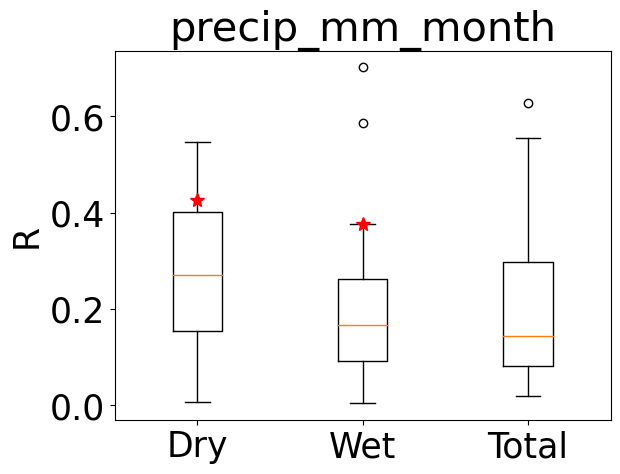

In [ ]:
areas = result['Area'].unique()  # Obter a lista de áreas únicas
varr = 'precip_mm_month'
start = 1985
end = 2020
pearson_coeffs_wet = []
pvalor_wet = []

for area in areas:
    df_area = result[result['Area'] == area]
    df_area = df_area[df_area['Type'] == 'Wet']
    df_area = df_area[df_area[varr].notnull()]

    x = df_area[["Percent", "date"]].values
    y = df_area[varr]

    def func(x, a, b):
        return a * x[:, 1] + b

    a0 = 1
    b0 = 1

    popt, pcov = curve_fit(func, x, y, p0=[a0, b0])
    y_pred = func(x, *popt)

    corr, pvalW = pearsonr(y, y_pred)
    pearson_coeffs_wet.append(corr)
    pvalor_wet.append(pvalW)

pearson_coeffs_dry = []
pvalor_dry = []

for area in areas:
    df_area = result[result['Area'] == area]
    df_area = df_area[df_area['Type'] == 'Dry']
    df_area = df_area[df_area[varr].notnull()]

    x = df_area[["Percent", "date"]].values
    y = df_area[varr]

    def func(x, a, b):
        return a * x[:, 1] + b

    a0 = 1
    b0 = 1

    popt, pcov = curve_fit(func, x, y, p0=[a0, b0])
    y_pred = func(x, *popt)

    corr, pvalD = pearsonr(y, y_pred)
    pearson_coeffs_dry.append(corr)
    pvalor_dry.append(pvalD)


pearson_coeffs_total = []
pvalor_total = []

for area in areas:
    df_area = result[result['Area'] == area]
    df_area = df_area[df_area['Type'] == 'Total']
    df_area = df_area[df_area[varr].notnull()]

    x = df_area[["Percent", "date"]].values
    y = df_area[varr]

    def func(x, a, b):
        return a * x[:, 1] + b

    a0 = 1
    b0 = 1

    popt, pcov = curve_fit(func, x, y, p0=[a0, b0])
    y_pred = func(x, *popt)

    corr, pvalT = pearsonr(y, y_pred)
    pearson_coeffs_total.append(corr)
    pvalor_total.append(pvalT)

titles = []
if varr == "mean_CH4":
    varr = "CH$_4$ [ppb]"
    titles = 'a)'
if varr == 'mean_CO2':
    varr = "CO$_2$ [ppm]"
    titles = 'b)'
if varr == 'maximum_2m_air_temperature':
    varr = "T$_{max}$ [°C]"
    titles = 'c)'
if varr == 'total_precipitation':
    varr = 'Total precipitation [mm]'
    titles = 'd)'
if varr == 'Num_Days':
    varr = 'Rainless days'
    titles = 'e)'

## Boxplot comparativo dos valores Dry, Wet e Total
data = [pearson_coeffs_dry, pearson_coeffs_wet, pearson_coeffs_total]
datap = [pvalor_dry, pvalor_wet, pvalor_tot]

labels = ['Dry', 'Wet', 'Total']

plt.figure()
plt.boxplot(data, labels=labels)
plt.xlabel('')
plt.ylabel('R')
plt.title(varr)


# Adicionar pontos com diferentes marcas aos boxplots
markers = ['*', '*', '*']  # Marcas dos pontos
idx = []


for i, box in enumerate(data):
    idx = np.where(np.array(datap[i]) > 0.05)
    box = np.array(box)

    if len(idx[0]) > 0:  # Verificar se existem índices válidos
        lim = np.max(box[idx])

        #print(lim)
        #print(idx)
        #print(box)

        if lim > 0:  # Verificar se lim é maior que 0
            plt.plot(i+1, lim, marker=markers[i], markersize=10, color='red')


os.chdir('G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/correlacoes/linear/')
plt.savefig(varr+'linear'+'.png', dpi=300, bbox_inches='tight')
plt.show()

pvalor_dry = pd.DataFrame(pvalor_dry)
pvalor_wet = pd.DataFrame(pvalor_wet)
pvalor_total = pd.DataFrame(pvalor_total)

df_pval = pd.DataFrame()
df_pval['Dry_pval'] = pvalor_dry
df_pval['Wet_pval'] = pvalor_wet
df_pval['Total_pval'] = pvalor_total

pearson_coeffs_dry = pd.DataFrame(pearson_coeffs_dry)
pearson_coeffs_wet = pd.DataFrame(pearson_coeffs_wet)
pearson_coeffs_total = pd.DataFrame(pearson_coeffs_total)

df_coef = pd.DataFrame()
df_coef['Dry'] = pearson_coeffs_dry
df_coef['Wet'] = pearson_coeffs_wet
df_coef['Total'] = pearson_coeffs_total

df_combined = pd.DataFrame()
df_combined = pd.concat([df_pval, df_coef],  axis=1)


#df_combined.to_csv(varr+'_linear'+'.csv', index=False)

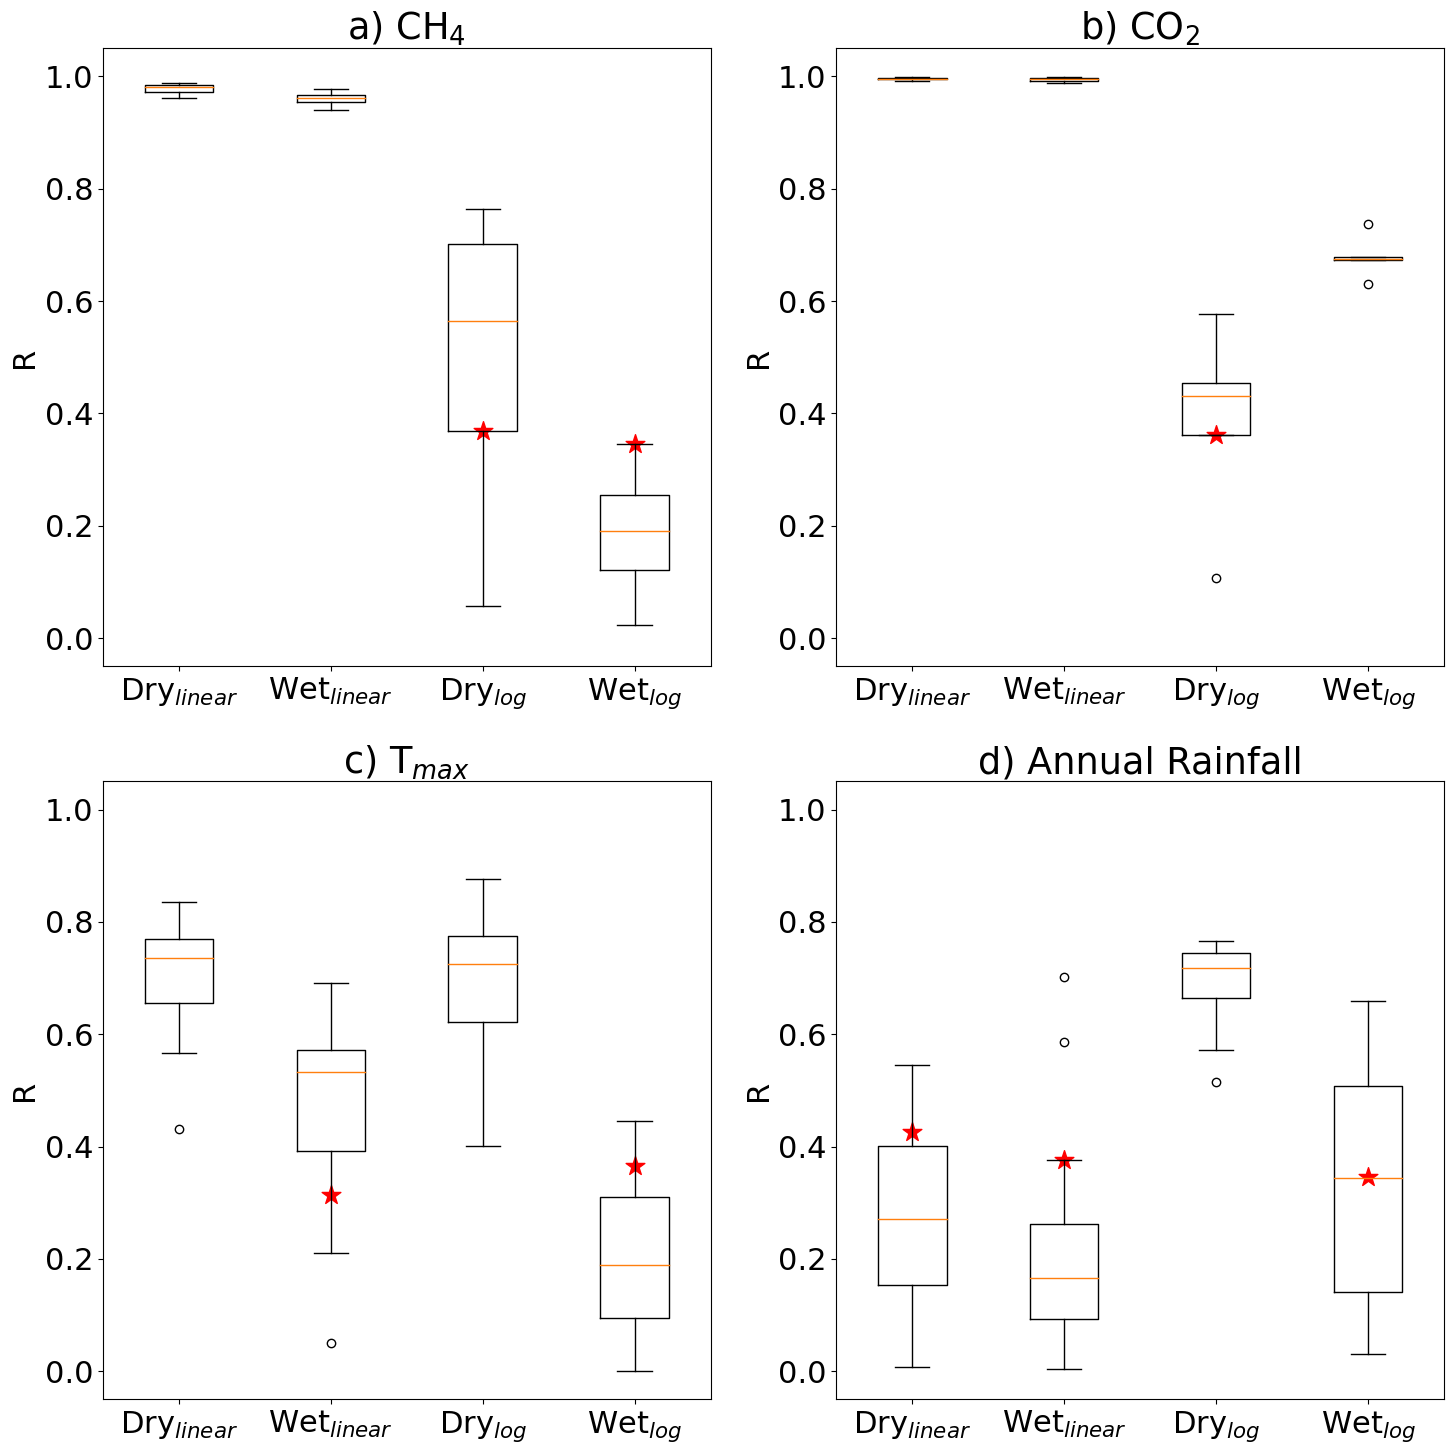

In [ ]:
# Linear fits
path = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/correlacoes/linear/'
arquivos = os.listdir(path)

# Filtra apenas os arquivos CSV
arquivos_csv = [arquivo for arquivo in arquivos if arquivo.endswith('.csv')]

# Log fits
path2 = 'G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/correlacoes/log/'
arquivos2 = os.listdir(path2)

# Filtra apenas os arquivos CSV
arquivos_csv2 = [arquivo for arquivo in arquivos2 if arquivo.endswith('.csv')]

# Configurações do plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
plt.rcParams.update({'font.size': 22})
flatten_axes = axes.flatten()
fig.tight_layout()

titles = ['a) CH$_4$', 'b) CO$_2$', 'c) T$_{max}$', 'd) Annual Rainfall']

for i, arquivo_csv in enumerate(arquivos_csv):
    caminho_arquivo = os.path.join(path, arquivo_csv)
    caminho_arquivo2 = os.path.join(path2, arquivo_csv)

    df = pd.read_csv(caminho_arquivo)
    df2 = pd.read_csv(caminho_arquivo2)

    valores_dry = df['Dry']
    valores_wet = df['Wet']

    valoresp_dry = df['Dry_pval']
    valoresp_wet = df['Wet_pval']

    valores_dry2 = df2['Dry']
    valores_wet2 = df2['Wet']

    valoresp_dry2 = df2['Dry_pval']
    valoresp_wet2 = df2['Wet_pval']

    data = [valores_dry, valores_wet, valores_dry2, valores_wet2]
    datap = [valoresp_dry, valoresp_wet, valoresp_dry2, valoresp_wet2]

    ax = flatten_axes[i]
    ax.boxplot(data, labels=['Dry$_{linear}$', 'Wet$_{linear}$', 'Dry$_{log}$', 'Wet$_{log}$'], showfliers=True)
    ax.set_title(titles[i])  # Define o título do boxplot com o nome do arquivo CSV
    ax.set_ylabel('R')
    ax.set_ylim([-0.05, 1.05])

    for j, box in enumerate(data):
        idx = np.where(np.array(datap[j]) > 0.05)
        box = np.array(box)

        if len(idx[0]) > 0:  # Verificar se existem índices válidos
            lim = np.max(box[idx])
            if lim > 0:  # Verificar se lim é maior que 0
                ax.scatter(j + 1, lim, marker='*', s=200, color='red')

#axes[2, 1].axis('off')
plt.tight_layout()
fig.set_facecolor('white')  # Definir o fundo branco

#os.chdir('G:/Outros computadores/USP_PC/Pos_Doutorado/Avaliação_território_ComparacaoGases/Documentos/Preparacao_Artigo/')
#plt.savefig('FigureS5.pdf', dpi=300, bbox_inches='tight')

plt.show()

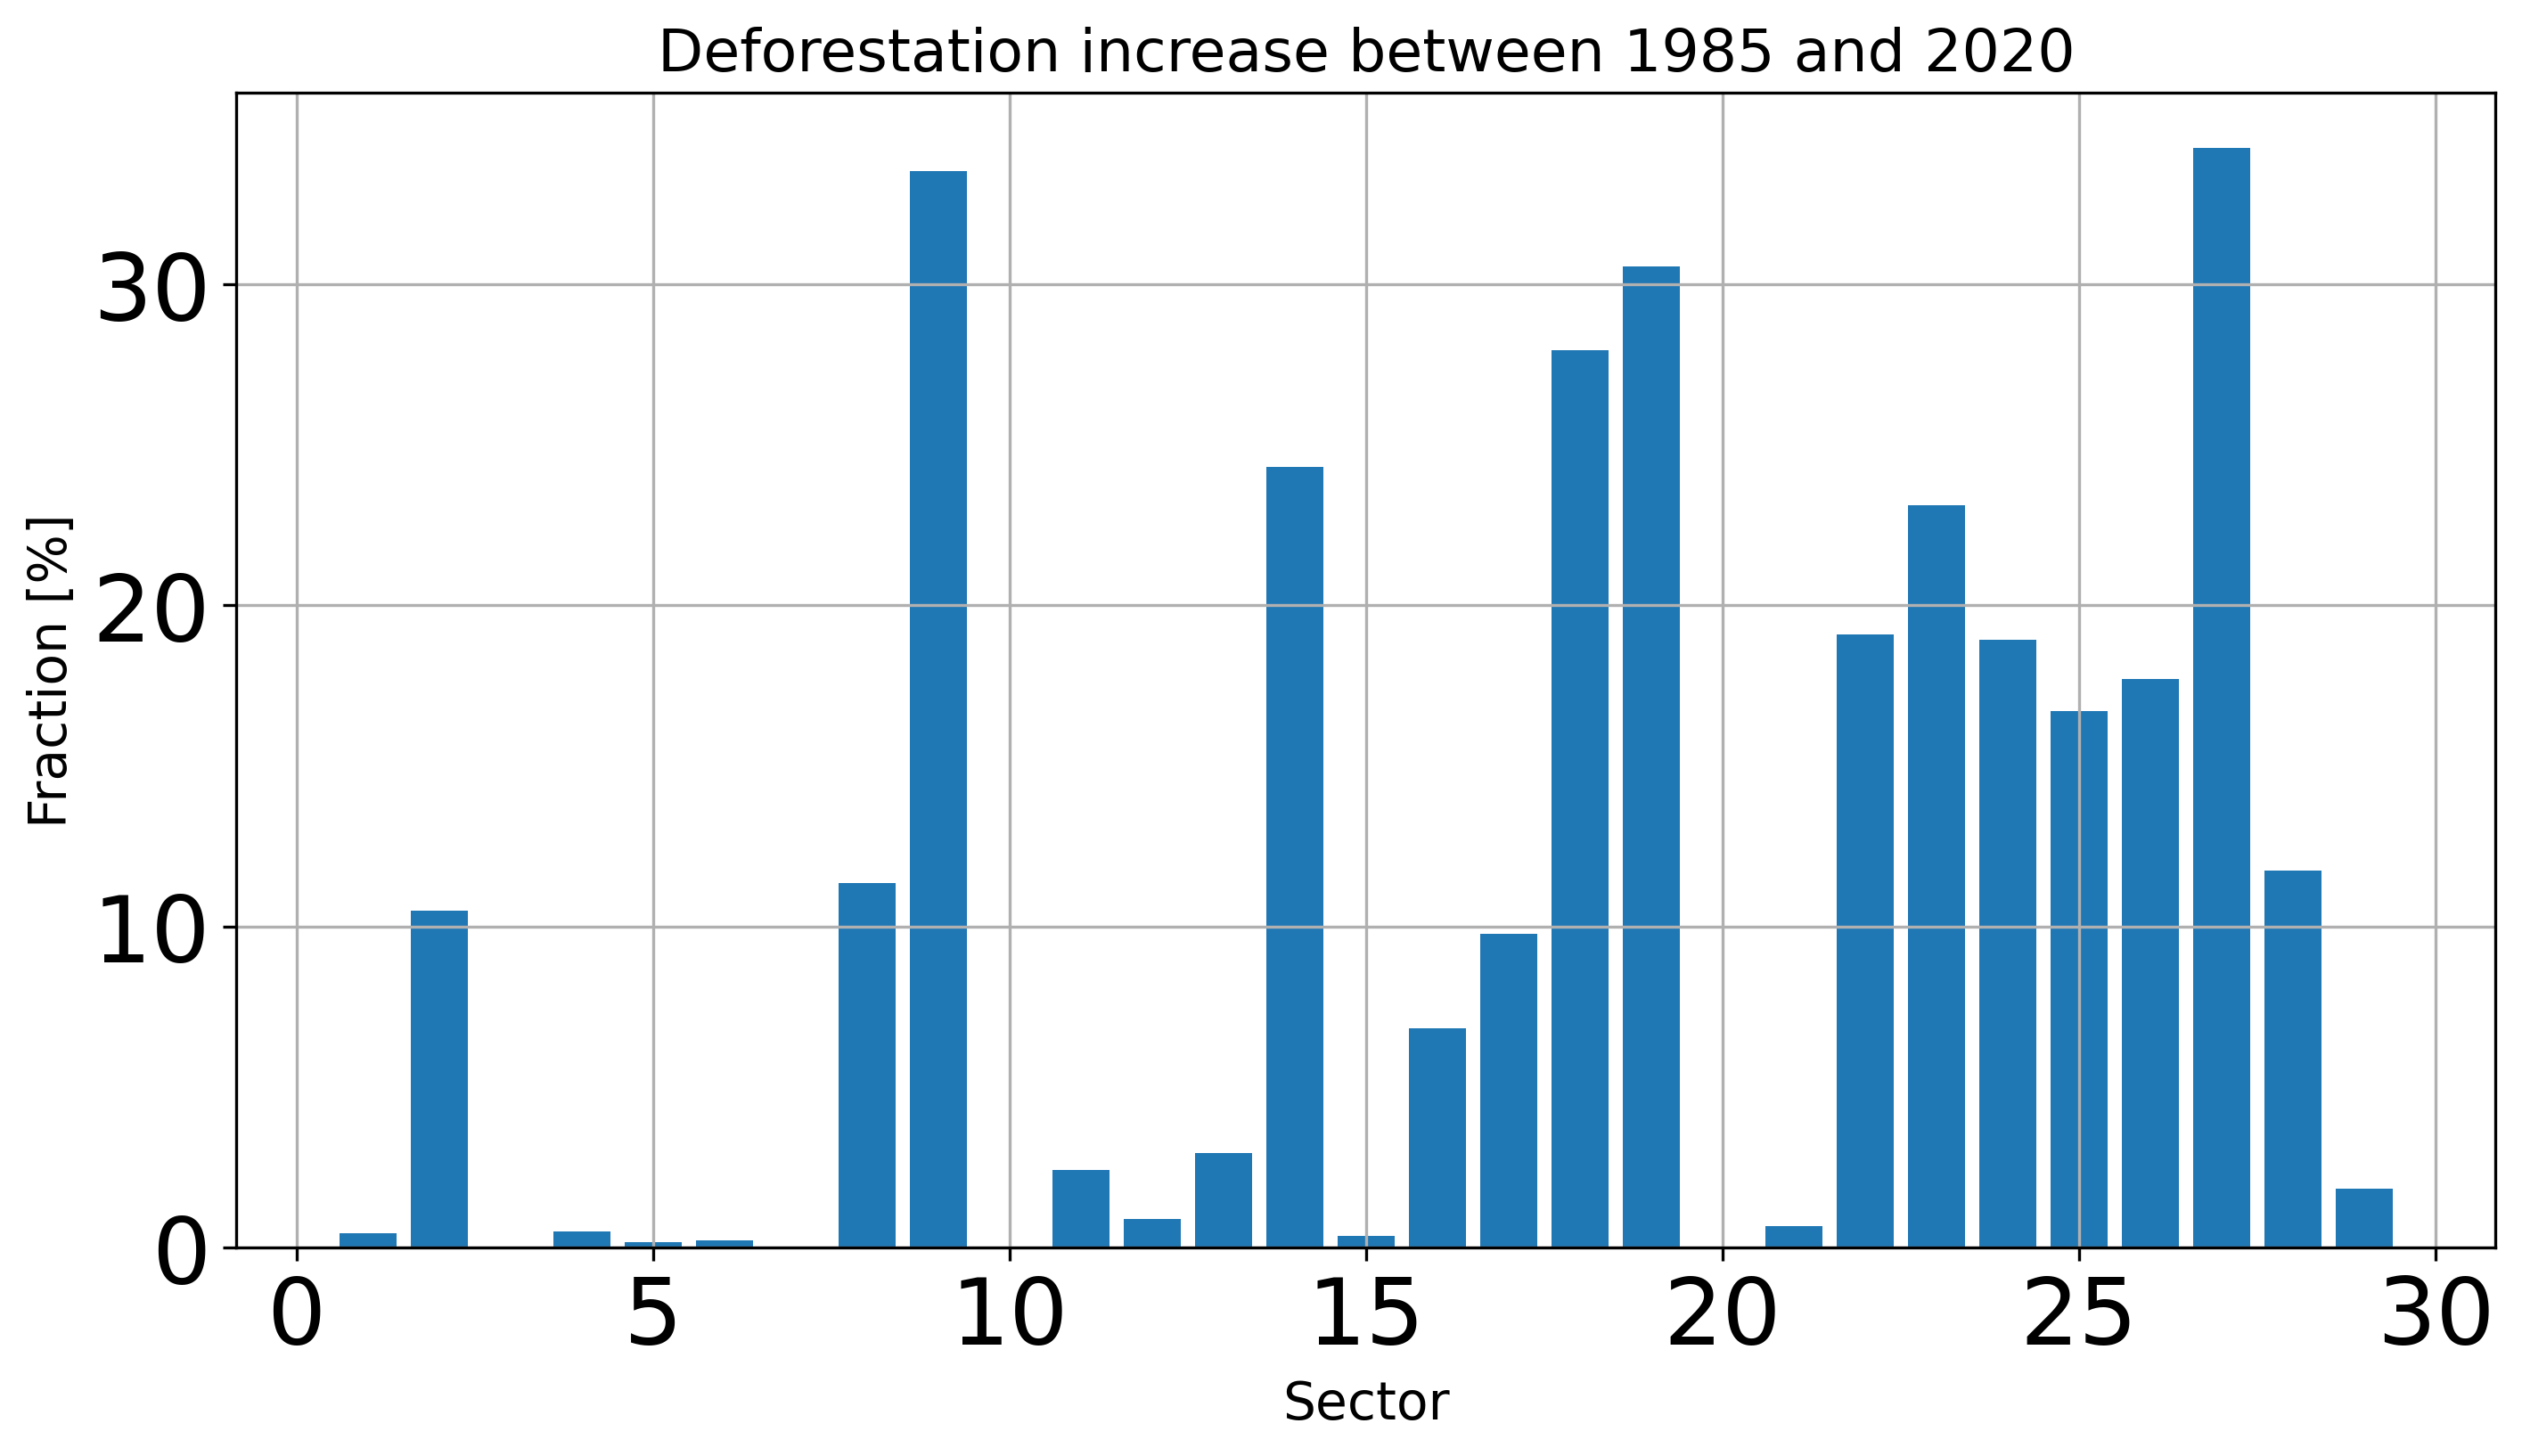

In [ ]:
df_dry = result[result['Type'] == 'Wet']
A1 = df_dry.query('date == 1985')['Percent'].reset_index(drop=True)
A2 = df_dry.query('date == 2020')['Percent'].reset_index(drop=True)

areaN = df_dry.query('date == 2019')['Area'].reset_index(drop=True)
delta_area = abs(A2 - A1)

dfareas = pd.DataFrame({
    'Area': areaN,
    'A1': A1,
    'A2': A2,
    'delta': delta_area
}).sort_values('Area')

plt.figure(figsize=(10, 6), dpi=300)
plt.bar(dfareas['Area'], dfareas['delta'])
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Fraction [%]', fontsize=14)
plt.title('Deforestation increase between 1985 and 2020', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()